In [1]:
import numpy as np

from qiskit import QuantumCircuit, execute, Aer
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

In [198]:
def QFT(n_qubits):
    qc = QuantumCircuit(n_qubits)
    
    for qubit in range(n_qubits):
        qc.h(qubit)
        theta = np.pi/2
        for c_qubit in range(qubit+1, n_qubits):
            qc.crz(theta=theta, control_qubit=c_qubit, target_qubit=qubit)
            theta /= 2
    
    for qubit in range(int(np.floor(n_qubits/2))):
        qc.swap(qubit, n_qubits-qubit-1)
        
    oracle = qc.to_gate()
    oracle.name = "QFT"
    
    return oracle

In [199]:
def apply_unitary(unitary, n_qubits):
    qc = QuantumCircuit(n_qubits+1)
    qc.h(range(n_qubits))
    
    for qubit in range(n_qubits):
        U = np.power(unitary, 2**(n_qubits-qubit-1))
        tmp_c = QuantumCircuit(1)
        tmp_c.unitary(U, 0)
        res = tmp_c.to_gate().control(1)
        
        qc.append(res, [qubit, n_qubits])
    
    return qc

In [200]:
def T_eigenstate_prep():
    qc = QuantumCircuit(1)
    qc.x(0)
    
    return qc.to_gate()

In [201]:
def QPE(unitary, state_prep, n_qubits):
    qc = QuantumCircuit(n_qubits+1, n_qubits)
    
#     prepare the target state
    qc.append(state_prep(), [n_qubits])
    
#     apply controlld unitaries
    qc.barrier()
    qc.append(apply_unitary(unitary, n_qubits), range(n_qubits+1))
    
#     apply QFT adjoint
    
    qc.barrier()
    qc.append(QFT(n_qubits).inverse(), range(n_qubits))
    
    qc.measure(range(n_qubits), range(n_qubits))
    
    return qc
    
    

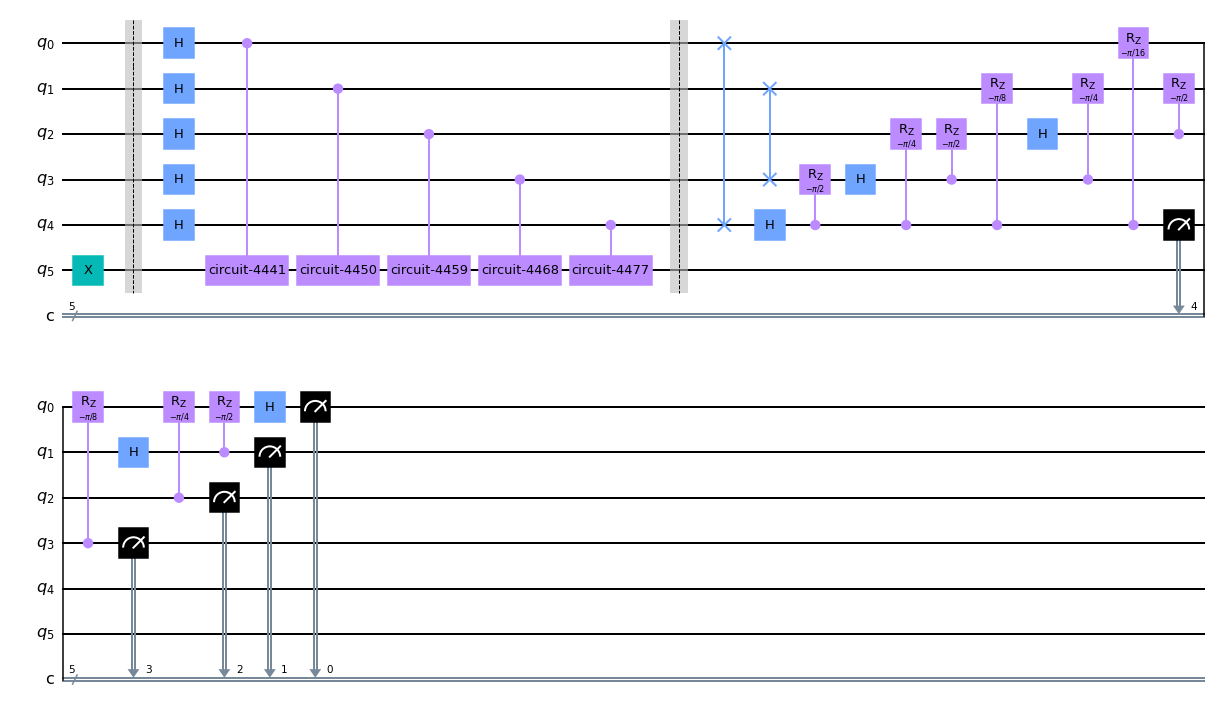

In [239]:
n_qubits = 5

secret_phase = 0.90
theta = 2*np.pi*secret_phase*1j

unitary = np.array([[np.exp(theta), 0],
                    [0, np.exp(theta)]])

circuit = QPE(unitary, T_eigenstate_prep, n_qubits)
circuit.decompose(reps=1).draw('mpl')

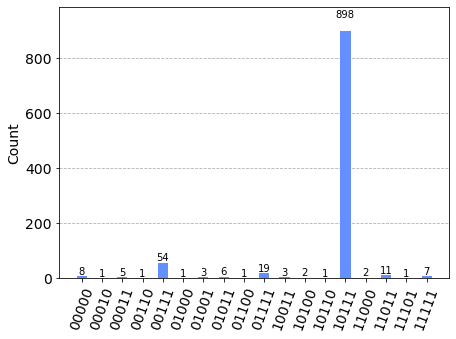

In [240]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

plot_histogram(answer)

In [241]:
max_value = 0
max_key = ''
for key, value in zip(results.get_counts().keys(), results.get_counts().values()):
    if value > max_value:
        max_key = key
        max_value = value

In [242]:
phase = int("".join(reversed(max_key)), 2) / 2**n_qubits
print(phase)

0.90625
